# **Clearskye X BDAB Pipeline**

<br />

##### **Goal**: #####

###### A maleable pipeline that harnesses machine learning in order to provide assistance in access management. 
<br />

##### **General Walkthrough**:
<br />

**Rules:**
The Rules (1 and 2) give a quick "indication" as to how likely a given account should have access to an entitlement given the rest of the data. This can be viewed as a simpler or more basic approach to predicting access that does not implement as much machine learning in the process. The rules are a more logical way of approaching the problem. They take in the memberships table and don't require a "yes" or "no" label unlike the models
Clarification: Wordnet is used for the rules. Logistic Regression and Random Forest are used for the custom-trained-model's prediction.
<br />

**Three machine learning models are utilized in this code: NLP Wordnet (semantics comparison), Logisitc Regression, and Random Forest.**
- The Wordnet model is the only model that comes pre-trained (aka ready for usage in predictions). Using this model, we're able to determine the similarity between words based on their actual meaning (semantics), which is used in Rule 1 for gauging the similarity of accounts.

- Logistic Regression and Random Forest are both examples of machine learning "classification" models, which are models actually trained in this code based on the data that is introduced by ClearSkye. These two models perform the same task, but in different ways under the hood, both chiefly concerned with generating a model that, when trained and given information about a new account, will provide a prediction around whether this account should be granted access based on previous accounts that the model has seen. Two different models, rather than only one, are provided in this code so that, when testing their performances on imported ClearSkye data, the model that performs better can be selected for future application. *Note: Given limitations with the ClearSkye data that the code was initially built with, it wasn't possible to determine which model would actually perform better, so they are now both made available to test and select.*

Finally, GridSearch sits at the very end of the code with the job of optimizing the Random Forest model by adjusting internal model parameters and comparing the permutations' performances. It then selects the best one and can be run as a model in its own right.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Rules (Getting the Data)

<br />

###### **Rule Definition**: 
A rule is a pre-programmed function that uses some logic to determine whether an account-entitlement pairing is reasonable (i.e. the account should be given access to the entitlement in question) or whether it needs further examination. This hypothetical account-entitlement pairing will be referred to from now on as the target account and target entitlement. We created two different rules. The first one gave the feature similarity between the target account and all other accounts that have access to the target entitlement, and used this feature similarity to provide a color indication of whether the account-entitlement pairing was reasonable. In contrast, the second rule returned the proportion of other accounts (with the same value for a certain feature) that shared the target entitlement, and used this proportion to also provide a color indication. The color indication varied from red to green with green and yellow signifying that the current account - entitlement pairing is reasonable with green establishing a higher level of confidence, and red signifying that the target account should not be given access to the requested entitlement, or at the very least, deeper analysis is required from the HR reviewer.
<br />
- The first step is to import the data (memberships data table where each row provided a pairing between a certain account and entitlement) and Python libraries, and convert the .csv file containing the memberships data table into a Pandas dataframe (memberships_df) for easier processing.

- Since we want a unique mapping between each account and the entitlements it has access to, we created a new dataframe called accounts_df, which was the memberships dataframe grouped by the accounts. This way, we could easily find the entitlements each unique account had access to.

In [7]:
#Loading the data
memberships_df = pd.read_csv("memberships.csv")
# Drop redundant columns
# Going to assume ilm_object is primary key
primary_account_key = "ilm_object"
primary_entitlement_key = "group.name"
memberships_df = memberships_df.drop(columns = ['group', 'group.source'], axis = 1)
memberships_df

,group.description,group.name,ilm_object,ilm_object.name,ilm_object.description,ilm_object.ref_x_cls_clear_skye_i_account.title,ilm_object.ref_x_cls_clear_skye_i_account.department,ilm_object.ref_x_cls_clear_skye_i_account.office,sys_created_on,sys_created_by,...,last_event,pre_transform,synchronized_by,sys_tags,sys_updated_on,sys_updated_by,sys_mod_count,valid_from,valid_to,object_id
0,Grp_0710980_glo_dist Global Group,$STVL00-EKDJ6F5INKPK,RozalinPas,RozalinPas,Master Fellow Manager,NaN,Accounting,Fremont,2021-03-08 23:24:42,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-08 23:24:42,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaacb5cdfcc-d841-...
1,Grp_0407789_glo_dist Global Group,$SUPC00-FM0CJGKKDKSQ,ThaliaLaw,ThaliaLaw,Junior Sales Rep Manager,NaN,Sales,Alameda,2021-03-06 10:49:39,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-06 10:49:39,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaad9476e8f-d289-...
2,Grp_0472679_glo_dist Global Group,$OCNE00-N6LFBR5D7TBT,LazloZau,LazloZau,Master Admin Normal,NaN,Accounting,Milpitas,2021-03-07 19:26:59,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-07 19:26:59,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaa192b7ed1-1686-...
3,Grp_0736517_glo_dist Global Group,$IIPM00-DROD8L2QJT6D,StarletGio,StarletGio,Master Fellow Employee,NaN,Accounting,Alameda,2021-03-05 23:10:35,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-05 23:10:35,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaaa6d09ca3-5f70-...
4,Grp_0014647_glo_dist Global Group,$OGO000-A7LEIV05SACU,KhalilMul,KhalilMul,Master Vice President Employee,NaN,Marketing,San Francisco,2021-03-10 06:52:08,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-10 06:52:08,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaaac5f98c4-0aa0-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Grp_0503080_glo_dist Global Group,$VPKF00-I18FRM205CCJ,CatherinDor,CatherinDor,Chief Sales Rep Employee,NaN,Accounting,San Francisco,2021-03-09 14:39:00,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-09 14:39:00,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaa5dd73b74-f14d-...
9996,Grp_0013208_glo_dist Global Group,$8FO000-6VTQA9QEBO1S,AlwynLoc,AlwynLoc,Associate Engineer Contract,NaN,Marketing,San Francisco,2021-03-07 02:03:56,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-07 02:03:56,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaab9c1cd11-592b-...
9997,Grp_0207593_glo_dist Global Group,$GGM600-FGFURJE71VKQ,AjmalHar,AjmalHar,Lead Sales Rep Employee,NaN,Accounting,Santa Clara,2021-03-04 14:38:46,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-04 14:38:46,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaa7ba0b6f4-25d7-...
9998,Grp_0010745_glo_dist Global Group,$BHK000-A1SI03HLGOHT,AureliaRoc,AureliaRoc,Master Assistant Contract,NaN,Marketing,San Francisco,2021-03-05 18:36:29,system,...,ATO00001002,NaN,Entitlements & Memberships Import,NaN,2021-03-05 18:36:29,system,0,NaN,NaN,2a76b6b31ba2e810b12275561a4bcbaaa3912cce-f41f-...


In [8]:
def account_entitlement_variables(memberships_df):
    accounts_df = memberships_df.groupby(primary_account_key).first()
    entitlements = {}
    for i in memberships_df.index:
        entitlement = memberships_df[primary_entitlement_key][i]
        account = memberships_df[primary_account_key][i]
        if entitlement in entitlements.keys():
            entitlements[entitlement].append(account)
        else:
            entitlements[entitlement] = [account]
    return entitlements, accounts_df

entitlement_to_accounts, accounts_df = account_entitlement_variables(memberships_df)
accounts_df = accounts_df.fillna("none")
accounts_df

,group.description,group.name,ilm_object.name,ilm_object.description,ilm_object.ref_x_cls_clear_skye_i_account.title,ilm_object.ref_x_cls_clear_skye_i_account.department,ilm_object.ref_x_cls_clear_skye_i_account.office,sys_created_on,sys_created_by,group_str,...,last_event,pre_transform,synchronized_by,sys_tags,sys_updated_on,sys_updated_by,sys_mod_count,valid_from,valid_to,object_id
ilm_object,,,,,,,,,,,,,,,,,,,,,
$1MU100-E17P27M7RV5H,Grp_0353422_glo_dist Global Group,$3T3B00-C6GKBHI4LCLR,$1MU100-E17P27M7RV5H,Grp_0053742_glo_dist Global Group,none,none,none,2021-03-06 11:19:56,system,2a76b6b31ba2e810b12275561a4bcbaa5642a449-46d2-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-06 11:19:56,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaae2818716-f212-...
$358C00-1DF8965HUA9C,Grp_0801056_glo_dist Global Group,$KRPO00-73JU40RURNJ1,$358C00-1DF8965HUA9C,Grp_0389750_glo_dist Global Group,none,none,none,2021-03-06 19:26:17,system,2a76b6b31ba2e810b12275561a4bcbaaadf8144b-c749-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-06 19:26:17,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaa5cdaab3b-26c7-...
$3FRO00-9NEOEPNPEONG,Grp_0313466_glo_dist Global Group,$QIS900-2EJKERO3F65O,$3FRO00-9NEOEPNPEONG,Grp_0803649_glo_dist Global Group,none,none,none,2021-03-09 14:55:36,system,2a76b6b31ba2e810b12275561a4bcbaa47d93d6b-383b-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-09 14:55:36,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaab36f9968-350e-...
$4D7E00-V5TP2DFJJQLQ,Grp_0202930_glo_dist Global Group,$HJH600-1F8JD2B8VE8N,$4D7E00-V5TP2DFJJQLQ,Grp_0454547_glo_dist Global Group,none,none,none,2021-03-07 04:13:17,system,2a76b6b31ba2e810b12275561a4bcbaa9cbef71b-82ed-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-07 04:13:17,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaabdcbc4e2-8c26-...
$4RE600-GESAH589CNVK,Grp_0290608_glo_dist Global Group,$P16900-OH3IP0BU1O87,$4RE600-GESAH589CNVK,Grp_0201607_glo_dist Global Group,none,none,none,2021-03-07 17:12:10,system,2a76b6b31ba2e810b12275561a4bcbaaae9bf51e-817e-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-07 17:12:10,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaadfd9d2d5-9dce-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZouheirAyo1,Grp_0601700_glo_dist Global Group,$9MMI00-6I4I05JEBSOA,ZouheirAyo1,Junior Evangelist Employee,none,Product Development,Alameda,2021-03-06 04:05:46,system,2a76b6b31ba2e810b12275561a4bcbaa20ac5bca-22c6-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-06 04:05:46,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaa0250bb9d-b538-...
ZouheirCha,Grp_0697110_glo_dist Global Group,$9LKL00-C7264HIRBF2B,ZouheirCha,Master Sales Rep Manager,none,Accounting,Redwood Shores,2021-03-09 20:51:40,system,2a76b6b31ba2e810b12275561a4bcbaadd88e08b-bfa9-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-09 20:51:40,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaa40d088bf-0163-...
Zsa zsaHig,Grp_0722988_glo_dist Global Group,$GIDM00-TIRFB6GFGJGR,Zsa zsaHig,Principal Developer Manager,none,IT,Palo Alto,2021-03-07 16:48:04,system,2a76b6b31ba2e810b12275561a4bcbaa3a6fe905-b4a3-...,...,ATO00001002,none,Entitlements & Memberships Import,none,2021-03-07 16:48:04,system,0,none,none,2a76b6b31ba2e810b12275561a4bcbaa8d6472b6-e53b-...


<br />

## Calculate Semantic Difference


- Next, we create helper functions in order to calculate rules 1 and 2. One of the helper functions we create (calculate_semantic_difference) takes two phrases of similar length and calculates the percent similarity between the two phrases using their underlying meaning rather than a naiive word equality comparison. This ensures that we don't give a similarity score of 0 for two words that inherently mean the same thing like "developer" and "engineer".

- To perform this similarity comparison, a natural language processing model called Wordnet was imported to handle semantic string comparison between account features like job title. Wordnet contains every single word in the English dictionary and the relationships between words (synonyms, antonyms, etc.) Thus, it was the perfect tool to use to get the semantic similarity between words since it captured the underlying meaning of each word. Thus, a limitation of this model would be for non-English text since Wordnet only contains relationships for English words.

In [9]:
from nltk.corpus import wordnet as wn

def calculate_semantic_difference(feature1, feature2):
    """ compute the feature similarity using Wordnet """
    # Tokenize and tag
    feature1 = feature1.split()
    feature2 = feature2.split()
    #Initialize variables
    score, count = 0.0, 0
    suffix = ".n.01"
    similarity_score = 0
    minWords = min(len(feature1), len(feature2))
    counter = 0
    # For each word in the first sentence
    for word1 in feature1:
        if counter == minWords:
            break
        # Get the similarity value of the most similar word in the other sentence
        best_score = getBestScore(word1, feature2, suffix)
        # Check that the similarity could have been computed
        if best_score is not None:
            similarity_score += best_score
        #Increment counter
        counter += 1
    # Average the values
    return similarity_score / minWords

#Gets the semantic similarity between a word and a list of other words
def getBestScore(target_word, other_words, suffix):
    best_score = -1
    for other_word in other_words:
        try:
            score = wn.synset(target_word + suffix).wup_similarity(wn.synset(other_word + suffix))
        except:
            score = 0
        if best_score == -1 or score > best_score:
            best_score = score
    return best_score

def getColor(percent_similarity): #returns a color based on percent similarity
    if (percent_similarity < 30):
        return "red"
    if (percent_similarity >= 30 and percent_similarity < 70):
        return "yellow"
    if (percent_similarity >= 70):
        return "green"

print(calculate_semantic_difference("System Administration", "Database Team"))

0.21978021978021978


<br />

## Rule 1 and 2 Implementation + Entropy

Here we actually implement rules 1 and 2. Like mentioned earlier, Rule 1 gave the feature similarity between the target account and all other accounts that have access to the target entitlement, and used this feature similarity to provide a color indication of whether the account-entitlement pairing was reasonable. On the other hand, Rule 2 returned the proportion of other accounts (with the same value for a certain feature) that shared the target entitlement, and used this proportion to also provide a color indication. The color indications provided are red, yellow, and green. A percent similarity less than 30% resulted in a red indication, a percent similarity between 30% and 70% resulted in a yellow indication, and a percent similarity above 70% resulted in a green indication. Obviously, these thresholds can be easily changed (look at getColor method above).

##### Regarding entropy:
The point of finding the entropy with the calculate_entropy function is to bring variance into scope for Rule 1. The entropy is only calculated when the semantic similarity returned from the Wordnet model is 0, indicating that the words given to this model are simply not comparable. An example would be locations (e.g. we likely don't want our model making predictions based on how similar a place like "San Jose" semantically is to "Berkeley"). When such an example arises, we calculate the entropy in order to capture how much variance or difference in every value there is within the column. Every column will have just one entropy score which is then inversed and multiplied by the percentage of values in the column that equal the target account's feature value. This product is finally multiplied by the sum of the inverses of all entropies within the data in order to provide context to the individual column's entropy.
##### Why entropy?
An example illuminating why entropy, or capturing variance, is useful would be to look at a circumstance where there is a software engineer applying for an entitlement. In one case, the accounts that already have access to the entitlement might all be HR managers. In the other case, the accounts that already have access to the entitlement might all be different and wildly varying, like a senior VP and an IT intern. Without taking variance into consideration, these two cases would be treated the same since the software engineer is the first "software engineer" accessing the entitlement. However, our team felt these two scenarios were different and should thus be treated differently, hence, entropy was introduced.

In [21]:
#Rule 1
def compare_feature_similarity(target_account, other_accounts, feature_key):
    matching_feature_similarity = 0
#     equivalent_value_count = 1
    target_account_feature = accounts_df.loc[target_account, feature_key]
    other_account_features = []
    for other_account in other_accounts:
        other_account_feature = accounts_df.loc[other_account, feature_key]
        other_account_features.append(other_account_feature)
        semantic_diff = calculate_semantic_difference(target_account_feature, other_account_feature)
        matching_feature_similarity += semantic_diff # TODO VERY IMPORTANT, IMPLEMENT
#         if other_account_feature == target_account_feature:
#             equivalent_value_count++
    matching_feature_similarity = matching_feature_similarity/len(other_accounts)
    if matching_feature_similarity == 0:
        entropy_weight = 1 / (calculate_entropy(np.unique(np.array(other_account_features), return_counts=True)[1]) + 1)
        unique_return_counts = np.unique(accounts_df[feature_key].to_numpy(), return_counts=True)[1]
        all_unique_counts = [np.unique(accounts_df[key].to_numpy(), return_counts=True)[1] for key in accounts_df.columns]
        total_variation = sum(unique_return_counts)
        percentage = accounts_df[feature_key].tolist().count(target_account_feature) / total_variation
        entropy_weight = 1 / (calculate_entropy(unique_return_counts) + 1)
        total_weight = sum([1 / (calculate_entropy(unique_count) + 1) for unique_count in all_unique_counts])
        matching_feature_similarity = (percentage * entropy_weight)/total_weight
    retColor = getColor(matching_feature_similarity * 100)
    return matching_feature_similarity, retColor

# Helper function for using entropy to determine variance in data
def calculate_entropy(arr):
    return - sum([x/sum(arr) * np.log2(x/sum(arr)) for x in arr])


# Given an entitlement and an account , gives the feature similarity between account and all accounts that have access to entitlement.
def rule_1(account, entitlement, feature_key):
    other_accounts = entitlement_to_accounts[entitlement]
    return compare_feature_similarity(account, other_accounts, feature_key)

# Given an entitlement and an account , collects all the other accounts in memberships such that their feature is equal to the account feature, then returns the proportion of accounts that have access to the entitlement.
def rule_2(account, entitlement, feature_key): #Here account is an IGA object, entitlement is the entitlement in the account-entitlement pairing, and feature_key is the feature being examined (title, office, description, etc.)
    primary_feature_key = feature_key
    target_account_feature = accounts_df.loc[account, feature_key]
    accounts_with_entitlement_df = memberships_df.loc[memberships_df[primary_feature_key] == target_account_feature]
    accounts = accounts_with_entitlement_df[primary_account_key].tolist()
    similarity_counter = 0
    for account in accounts:
        other_account_entitlement = accounts_df.loc[account][primary_entitlement_key]
        if other_account_entitlement == entitlement:
            similarity_counter += 1
    matching_entitlement_similarity = similarity_counter/len(accounts)
    retColor = getColor(matching_entitlement_similarity * 100)
    return matching_entitlement_similarity, retColor

... #Space to add more rules here!


# Sample Testing on a few parameters
semantic_similarity,  color1 = rule_1("ZubenDut", "$P5HE00-HKU1890C656T", "ilm_object.ref_x_cls_clear_skye_i_account.office")
matching_entitlement_similarity, color2 = rule_2("ZubenDut", "$P5HE00-HKU1890C656T", "ilm_object.ref_x_cls_clear_skye_i_account.department")
print("Rule 1 percent similarity: " + str(semantic_similarity) + " and resulting indication: " + color1)
print("Rule 2 percent similarity: " + str(matching_entitlement_similarity) + " and resulting indication: " + color2)

Rule 1 percent similarity: 0.0005668087854950308 and resulting indication: red
Rule 2 percent similarity: 0.0019551616266944736 and resulting indication: red


## Rule Testing Rig
A modifiable cell for testing the previously defined rules on samples of the data.

In [23]:
# number of accounts to test
account_sample_size = 3
# randomly select sample_size of accounts
account_sample_df = accounts_df.sample(n=account_sample_size)

# number of entitlements to test per account
ent_sample_size = 1
# randomly select sample_size of entitlements
ent_sample_df = memberships_df.sample(n=ent_sample_size)

# columns to focus on in rule 1 and other rules that require a column of focus
columns_of_interest = ["ilm_object.description", "ilm_object.ref_x_cls_clear_skye_i_account.department",
                       "ilm_object.ref_x_cls_clear_skye_i_account.office"]

# iterates through every account in the generated sample account dataframe
for account_row in account_sample_df.iterrows():
    account = account_row[0]

    # iterates through every entitlement in the generated sample entitlement dataframe for every account iteration
    for ent_row in ent_sample_df.iterrows():
        ent = ent_row[1][1]
        print("Ent: " + ent + " | Account: " + account)

        # Rule 1 Testing
        # iterates through every column listed above for every entitlement iteration
        for col in columns_of_interest:
            semantic_similarity,  color1 = rule_1(account, ent, col)
            print("\tRule 1 for \"" + col + "\" percent similarity: " + str(semantic_similarity) + " and resulting indication: " + color1)

        # Rules 2 Testing
        for col in columns_of_interest:
            matching_entitlement_similarity, color2 = rule_2(account, ent, col)
            print("\tRule 2 percent similarity: " + str(matching_entitlement_similarity) + " and resulting indication: " + color2)


Ent: $Q80F00-VPROLP9VF6O9 | Account: OhioSob
	Rule 1 for "ilm_object.description" percent similarity: 0.6761385176346815 and resulting indication: yellow
	Rule 1 for "ilm_object.ref_x_cls_clear_skye_i_account.department" percent similarity: 0.25 and resulting indication: red


	Rule 1 for "ilm_object.ref_x_cls_clear_skye_i_account.office" percent similarity: 0.0006202453039928788 and resulting indication: red
	Rule 2 percent similarity: 0.0 and resulting indication: red
	Rule 2 percent similarity: 0.0 and resulting indication: red
	Rule 2 percent similarity: 0.012077294685990338 and resulting indication: red
Ent: $Q80F00-VPROLP9VF6O9 | Account: KatyBoe
	Rule 1 for "ilm_object.description" percent similarity: 0.47858570737827716 and resulting indication: yellow
	Rule 1 for "ilm_object.ref_x_cls_clear_skye_i_account.department" percent similarity: 0.25 and resulting indication: red


# Cleaning the Model Data (Review Data)

###### In order to fit our model to the data, we need to process the tables first, and then split it into training and test sets.  
* First, we started off by removing rows with no information in it. We then split the title feature into 3 different features (title1, title2, and title3) in order for our model to recognize patterns within the titles, for example splitting "Senior Computer Engineer" into "Senior", "computer", and "engineer."
* We then one hot encode the data, meaning turning the categorical features into 1s and 0s that our model can actually train on.  The final step is to do a random split in our data in order to get valid testing and training data. The data was randomly split so that 70% went to training the model and the other 30% was used for testing our model's accuracy. Keep in mind that the review data (realData.csv), unlike the data we used for our rules section (memberships.csv), was labeled as to whether we keep access to the given entitlement pairing or remove access.
* We will run the model training and testing pipeline separately on both realData.csv and the unlabeled data used in the rules section. This is to show that the engineered trends in the memberships data are picked up by the model. For the unlabeled data, we generate negatives by creating random permutations of unique column values from the positive data (done in the generate_random_negatives function)

In [8]:
def shrinker(df):
    #prune cols that have no values
    description = df.describe(include="all")
    description = description.transpose()
    nonzero_df = df[description[description["count"] > 0].index] 
    #prune cols comprised of only one value
    non_redundant = []
    for col in nonzero_df.columns.values:
        if len(np.unique(nonzero_df[col].tolist())) > 1:
            non_redundant.append(col)
    return nonzero_df[non_redundant]

In [9]:
def split_titles(mem_df):
    mem_df['split_title'] = mem_df['parent.ilm_object.description'].str.split()
    max_words = mem_df['split_title'].str.len().max()
    mem_df['split_title'].apply(lambda x : (x.extend(['' for i in range(max_words - len(x))]) or x))
    df1 = pd.DataFrame(mem_df['split_title'].to_list(), columns=['title' + str(i) for i in range(0, max_words)])
    mem_df = pd.concat([mem_df, df1], axis = 1)
    return mem_df

In [20]:
def split_titles_mems(mem_df):
    mem_df['split_title'] = mem_df['ilm_object.description'].str.split()
    max_words = mem_df['split_title'].str.len().max()
    mem_df['split_title'].apply(lambda x : (x.extend(['' for i in range(max_words - len(x))]) or x))
    df1 = pd.DataFrame(mem_df['split_title'].to_list(), columns=['title' + str(i) for i in range(0, max_words)])
    mem_df = pd.concat([mem_df, df1], axis = 1)
    return mem_df

In [10]:
def rearrange_columns(df):
  colNames = list(df.columns.values)
  colNames.pop(colNames.index('action'))
  colNames.pop(colNames.index('ilm_object'))
  return df[['ilm_object','action'] + colNames]

In [31]:
def generate_random_negatives(df_clean):
    df_length = df_clean.shape[0]
    df_cross = df_clean.copy()
    df_cross['action'] = np.full(df_length, 1)
    df_dict = {}
    for col, values in df_cross.iteritems():
        if col == 'action':
            df_dict[col] = np.full(df_length, 0)
        else:
            df_dict[col] = np.random.choice(np.unique(values.tolist()), size = df_length)
    df_cross = df_cross.append(pd.DataFrame(df_dict))
    return df_cross

In [32]:
def one_hot_encoding_action(df):
    OH_enc = OneHotEncoder()
    X = OH_enc.fit_transform(df.drop(['action', 'ilm_object'], axis = 1))
    y = df['action']
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=300)
    return train_X, test_X, train_y, test_y, OH_enc

In [33]:
def preprocessing(data):
    mem_df = shrinker(data)
    mem_df = split_titles(mem_df)
    mem_df_clean = mem_df.fillna('')
    mem_df_clean = rearrange_columns(mem_df_clean)
    mem_df_clean.drop(
        ["parent.ilm_object.description", "parent", "split_title"],
        axis=1,
        inplace=True)
    mem_df_clean.rename(columns={
        "parent.ilm_object.ref_x_cls_clear_skye_i_account.department":
        "department",
        "parent.ilm_object.ref_x_cls_clear_skye_i_account.office":
        "office"
    },
                        inplace=True)
    mem_df_clean["action"] = mem_df_clean["action"].apply(
        lambda x: 1 if x == "Keep Access" else 0)
    train_X, test_X, train_y, test_y, encoder = one_hot_encoding_action(
        mem_df_clean)
    return mem_df_clean, train_X, test_X, train_y, test_y, encoder

In [93]:
#Preprocessing pipeline specifically for memberships_df.

def preprocessing_mems(data):
    mem_df = shrinker(data)
    mem_df = split_titles_mems(mem_df)
    mem_df_clean = mem_df.fillna('')
    mem_df_clean.drop(["ilm_object.description", "split_title", "group.description", "group", "group.name", "ilm_object.name", "group_str", "ilm_object_str", "object_id", "group.source", "sys_created_on", "sys_updated_on"],axis=1,inplace=True)
    mem_df_clean.rename(columns={
        "ilm_object.ref_x_cls_clear_skye_i_account.department":
        "department",
        "ilm_object.ref_x_cls_clear_skye_i_account.office":
        "office"
    },
                        inplace=True)
    mem_df_clean = generate_random_negatives(mem_df_clean)
    train_X, test_X, train_y, test_y, encoder = one_hot_encoding_action(
        mem_df_clean)
    return mem_df_clean, train_X, test_X, train_y, test_y, encoder

### Load Data Here (For the user To enter) 

In [87]:
#load in your data (Currently working with the review data)
review_data = pd.read_csv('realData.csv')
#RUN PREPROCESSING FUNCTION ON YOUR DATA
preprocessed_data, train_X, test_X, train_y, test_y, encoder = preprocessing(review_data)
preprocessed_data

,ilm_object,action,department,office,title0,title1,title2,title3
0,All Sales Users,1,Sales,Emeryville,Chief,Technician,Manager,
1,All Sales Users,0,Sales,Fremont,Junior,Consultant,Normal,
2,All Legal Department Users,1,Legal Department,Milpitas,Principal,Fellow,Employee,
3,All Legal Department Users,1,Legal Department,Redmond,Junior,Coordinator,Employee,
4,All Legal Department Users,1,Legal Department,Orem,Junior,President,Contract,
...,...,...,...,...,...,...,...,...
49894,All Product Testing Users,1,Product Testing,Emeryville,Chief,Admin,Contract,
49895,All Sales Users,0,Sales,Fremont,Senior,Inspector,Manager,
49896,All Product Testing Users,0,Product Testing,Cupertino,Associate,Visionary,Contract,
49897,All Product Testing Users,0,Product Testing,Abuja,Master,Manager,Normal,


# Cleaning the Model Data (Randomly Generated Negative Data)

###### We followed the same preprocessing steps for the membership dataset with the randomly generated negative data with a few exceptions.  
* The one exception (between the data cleaning for the reviewed dataset and the membership dataset) was that we randomly generated half of the rows (10,000 for this particular dataset) to have a fit of 0, meaning that the given account should not have access to the given entitlement. To generate these negative rows, we basically took random permutations of the values in each column and assigned that random permutation to an account/IGA object, which we added as a row to the dataset. Since we generated 10,000 accounts with a negative mapping to their respective entitlements, 10,000 rows were added. 

In [94]:
#load in your data (Currently working with the memberships/randomly generated negative data)
memberships_data = pd.read_csv('memberships.csv')
#RUN PREPROCESSING FUNCTION ON YOUR DATA
preprocessed_mecmberships_data, train_memberships_X, test_memberships_X, train_memberships_y, test_memberships_y, encoder_memberships = preprocessing_mems(memberships_data)
preprocessed_memberships_data

,ilm_object,department,office,title0,title1,title2,title3,action
0,RozalinPas,Accounting,Fremont,Master,Fellow,Manager,,1
1,ThaliaLaw,Sales,Alameda,Junior,Sales,Rep,Manager,1
2,LazloZau,Accounting,Milpitas,Master,Admin,Normal,,1
3,StarletGio,Accounting,Alameda,Master,Fellow,Employee,,1
4,KhalilMul,Marketing,San Francisco,Master,Vice,President,Employee,1
...,...,...,...,...,...,...,...,...
9995,FrancoisFul,Legal Department,Cambridge,Senior,Director,President,Normal,0
9996,AmandaEsr,Management,Dresden,Grp_0153485_glo_dist,Inspector,President,,0
9997,BrekelHat,Administrative,,Associate,Accountant,Normal,Employee,0
9998,MeadeKut,Legal Department,Abuja,Grp_0069055_glo_dist,Auditor,Rep,Employee,0


# Our Models

## Logistic Regression

###### Logistic Regression is a simple machine learning model that optimizes an equation in order to get the best predictions for a classifier.  
<br />

- While the actual math is too much to cover here, it basically takes a logistic equation and optimizes the coefficients in order to get the highest accuracy.

- An important statistic of the model to look at is accuracy and number of true positives, true negatives, false positives, and false negatives which can tell you how the model works with the data.

In [37]:
# Imports

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [38]:
# Logistic Regression Model
def train_log_reg_model(train_X, train_y, test_X, test_y):
    logreg = LogisticRegression(random_state=88)
    # train the logistic regression model
    logreg.fit(train_X, train_y)
    # print logistic regression model performance
    prob_y = logreg.predict_proba(test_X)
    pred_y = pd.Series([1 if x > 0.5 else 0 for x in prob_y[:,1]], index=test_y.index)
    cm = confusion_matrix(test_y, pred_y)
    print ("\nAccuracy:", accuracy_score(test_y, pred_y))
    print ("Confusion Matrix: \n", cm)

In [76]:
#For reviewed dataset
train_log_reg_model(train_X, train_y, test_X, test_y) 


Accuracy: 0.4989311957247829
Confusion Matrix: 
 [[3641 3781]
 [3720 3828]]


In [95]:
#For memberships/randomly generated negative rows dataset
train_log_reg_model(train_memberships_X, train_memberships_y, test_memberships_X, test_memberships_y)


Accuracy: 0.9675
Confusion Matrix: 
 [[2876  115]
 [  80 2929]]


##### Confusion Matrix Visual Example
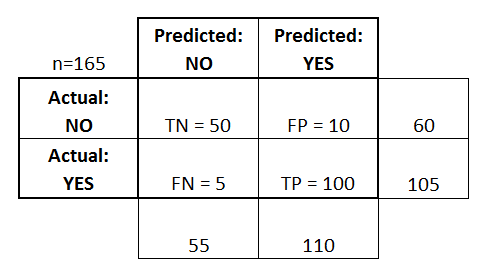
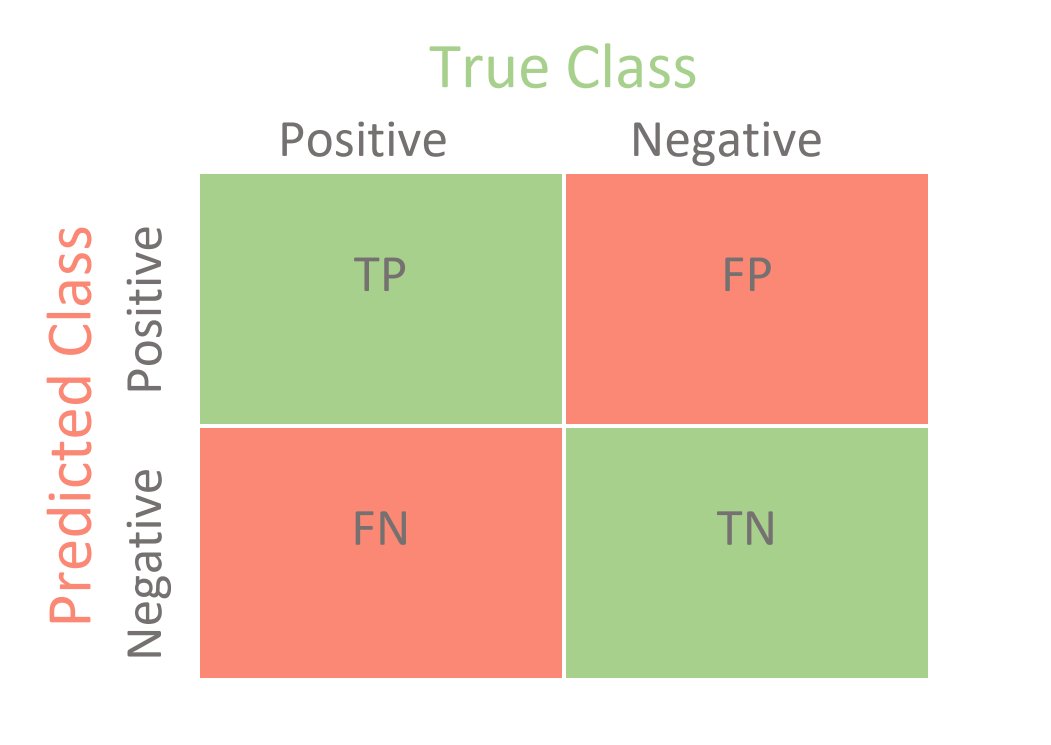

## Random Forest

###### A random forest model is a made up of a group of decision trees which all are trained on random features of the dataset, which gives the name random forest. 
<br />

- Each decision tree takes in its randomly selected training data, trains on that data, and outputs a result for a given prediction. 

- The model then outputs the result that a majority of the decision trees came to, which helps prevent overfitting (a major obstacle that comes from using single decision trees).

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
def train_random_forest_model(train_X, train_y, test_X, test_y):
    # train the random forest model
    forest_model = RandomForestClassifier()
    forest_model.fit(train_X, train_y)

    # print random forest model performance
    pred_y = forest_model.predict(test_X)
    cm = confusion_matrix(test_y, pred_y)
    print ("\nAccuracy:", accuracy_score(test_y, pred_y))
    print ("Confusion Matrix: \n", cm)
    return forest_model


In [44]:
#Random Forest trained on review data

forest_model = train_random_forest_model(train_X, train_y, test_X, test_y)


Accuracy: 0.5106880427521711
Confusion Matrix: 
 [[3768 3654]
 [3671 3877]]


In [96]:
#Random Forest trained on unlabeled data with randomly generated negatives

forest_model_mems = train_random_forest_model(train_memberships_X, train_memberships_y, test_memberships_X, test_memberships_y)


Accuracy: 0.978
Confusion Matrix: 
 [[2912   79]
 [  53 2956]]


## Feature Importance

###### An interesting attribute of the random forest model is its feature importance.  Through this attribute, the model will display the relative weights it attributes to each feature.
- For example, with the given sample data the office had the most weight, which means that the office feature of the dataset had the greatest effect on the random forest model's prediction (whether the account-entitlement pairing should be accepted)

In [55]:
def getRF_FeatureImportance(model, encoder):
  # Map feature Importance from encoder features to column names
  importance = model.feature_importances_
  feature_names = encoder.get_feature_names()
  x_Importance, feature_Importance, curString = {}, {}, 'x'
  for i,v in enumerate(importance):
    featureName = feature_names[i]
    if curString != featureName[0:2]:
      curString = featureName[0:2]
      x_Importance[curString] = 0
    x_Importance[curString] += v


  columnNames, keys = preprocessed_data.columns[2:], list(x_Importance.keys())
  for i in range(0, len(x_Importance)):
    feature_Importance[columnNames[i]] = x_Importance[keys[i]]
  return feature_Importance

In [30]:
#Get feature importance for model created from reviewed data
getRF_FeatureImportance(forest_model, encoder) 

{'department': 0.10472274587240142,
 'office': 0.33249147058703316,
 'title0': 0.19621611374669323,
 'title1': 0.26645016926280196,
 'title2': 0.07864308542910356,
 'title3': 0.021476415101966684}

In [97]:
#Get feature importance for model created from randomly generated negative data
getRF_FeatureImportance(forest_model_mems, encoder_memberships)

{'department': 0.3461312414142374,
 'office': 0.059657894270183656,
 'title0': 0.10281410945234286,
 'title1': 0.08209045095160848,
 'title2': 0.09927881691147208,
 'title3': 0.31002748700015553}

## Cross Validation Example

###### Cross validation (CV) is the process of finding the best parameters for our model.
<br />

- In CV, a model is tested with various different parameters in order to find the one with the best accuracy.  For each parameter, the data is split into 5 different folds and each fold is trained separately.  The average accuracy across the folds is the overall accuracy for the current parameter.

- In this case, we trained a new random forest classifier while testing different numbers of max features.  We used 5 splits, or folds, for each max feature. 

In [77]:
from sklearn.model_selection import KFold
grid_values = {'max_features': np.linspace(1,7,7, dtype='int32'), 'min_samples_leaf':[5],'n_estimators':[500], 'random_state':[88]}

rfc = RandomForestClassifier()
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rfc_cv = GridSearchCV(rfc, param_grid=grid_values, scoring='accuracy', cv=cv, verbose=2).fit(train_X,train_y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  18.0s


[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  22.4s


[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  15.9s


[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  15.9s


[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  15.9s


[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.7s


[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  24.6s


[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.3s


[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.8s


[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.4s


[CV] END max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  25.4s


[CV] END max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  28.1s


[CV] END max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  25.3s


[CV] END max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  26.3s


[CV] END max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  26.0s


[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  29.6s


[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  32.2s


[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  29.6s


[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  31.8s


[CV] END max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  31.6s


[CV] END max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.3s


[CV] END max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.2s


[CV] END max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.1s


[CV] END max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  35.1s


[CV] END max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  35.8s


[CV] END max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  39.4s


[CV] END max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  43.1s


[CV] END max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  40.8s


[CV] END max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  42.8s


[CV] END max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  41.5s


[CV] END max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  45.6s


[CV] END max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  48.5s


[CV] END max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  45.9s


[CV] END max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  44.9s


[CV] END max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  46.4s


In [83]:
rfc_cv.best_estimator_.get_params()
prob_y = rfc_cv.predict_proba(test_X)
pred_y = pd.Series([1 if x > 0.5 else 0 for x in prob_y[:,1]], index=test_y.index)
cm = confusion_matrix(test_y, pred_y)
print ("\nAccuracy:", accuracy_score(test_y, pred_y))
print ("Confusion Matrix: \n", cm)


Accuracy: 0.5032064128256513
Confusion Matrix: 
 [[3657 3765]
 [3672 3876]]
